In [1]:
import torch
import torchvision
import time
import random
import math
import json

from PIL import Image, ImageFont, ImageDraw

In [2]:
alphabet = ['*','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
random.seed(100)
alphabetColors = [(random.randrange(256),random.randrange(256),random.randrange(256)) for i in alphabet]
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        color = alphabetColors[label]
        
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

def displayGroups(image, results, groupsIndices):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for g in groupsIndices:
        for i in results['groups'][g]:
            coord = results['boxes'][i]
            label = results['labels'][i]
            x1 = coord[0]
            y1 = coord[1]
            x2 = coord[2]
            y2 = coord[3]
            color = alphabetColors[label]

            draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
            draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)
    
loadingStrings = [' ','▏','▎','▍','▌','▋','▊','▉','█']
def printLoadingBar(percentage:float, length:int, startTime:float):
    if percentage==0.0:
        print(" " + "_"*length)
    
    nbFilled = max(0, min(length, int(length*percentage)))
    remainder = length*percentage - int(length*percentage)
    strRemainder = loadingStrings[int(remainder*len(loadingStrings))]
    strPercentage = "{0:.2f}%".format(100*percentage) 
    isBarFull = int(nbFilled!=length)
    bar = "▕" + "█"*(nbFilled) + isBarFull*strRemainder + " "*(length-nbFilled-1) + "▏" + strPercentage
    
    ellapsedTime = time.time() - startTime
    eta = 0.0 if percentage==0.0 else ellapsedTime*((1-percentage)/percentage)
    isMinute = int(int(eta)>=60)
    isZero = int(percentage<0.99999)
    strEta = isMinute*"{0}m".format(int(eta)//60) + isZero*"{0}s".format(int(eta)%60)
    
    buffer = " "*(length+20)
    
    print(buffer,end="\r")
    print(bar + " " + strEta,end="\r")

In [3]:
evalModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=27, # alphabet+background
    box_detections_per_img=2000,
    
    rpn_pre_nms_top_n_train=2000, #number of proposals to keep before applying NMS during training
    rpn_pre_nms_top_n_test=2000, #number of proposals to keep before applying NMS during testing
    rpn_post_nms_top_n_train=2000, #number of proposals to keep after applying NMS during training
    rpn_post_nms_top_n_test=2000, #number of proposals to keep after applying NMS during testing
    rpn_batch_size_per_image=32768 #number of anchors
)
evalModel.eval()
#evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V18.pth"))
evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V20_font100-240.pth"))

<All keys matched successfully>

In [12]:
def sortResults(result):
    
    indices = result['scores'].argsort(dim=0, descending=True)
    indices4 = indices.repeat(4,1).transpose(1,0)
    
    result2 = {'groups':[], 'neighbors':[]}
    
    result2['boxes'] = result['boxes'].gather(index=indices4,dim=0)
    result2['labels'] = result['labels'].gather(index=indices,dim=0)
    result2['scores'] = result['scores'].gather(index=indices,dim=0)
    
    indicesList = indices.tolist()
    indicesReverse = {str(indicesList[i]):i for i in range(len(indicesList))}
    for group in result['groups']:
        #result2['groups'].append([indicesList[i] for i in group])
        result2['groups'].append(sorted([indicesReverse[str(i)] for i in group]))
        
    for neighborsGroup in result['neighbors']:
        #result2['neighbors'].append([indicesList[i] for i in neighborsGroup])
        result2['neighbors'].append(sorted([indicesReverse[str(i)] for i in neighborsGroup]))
        
    return result2

def vizTensor(tensor):
    T = torchvision.transforms.ToPILImage()
    display(T(tensor))

def filterResults(result, min_score):
    i = 0
    while i < len(result['scores']) and result['scores'][i] > min_score:
        i+=1
        
    result['boxes'] = result['boxes'][:i]
    result['labels'] = result['labels'][:i]
    result['scores'] = result['scores'][:i]
    
    for j,group in enumerate(result['groups']):
        result['groups'][j] = [n for n in group if n<i]
        
    for j,neighborsGroup in enumerate(result['neighbors']):
        result['neighbors'][j] = [n for n in neighborsGroup if n<i]

def resultsToLists(result):
    result['boxes'] = result['boxes'].tolist()
    result['labels'] = result['labels'].tolist()
    result['scores'] = result['scores'].tolist()
    
def computeNeighbors(result,nX,nY,reach):
    nGroups = nX*nY
    result['neighbors'] = [[] for i in range(nGroups)] #adds self as neighbors for the full-sized group
    
    #result['neighbors'][nGroups].extend(result['groups'][nGroups])
    
    for x in range(nX):
        for y in range(nY):
            group = (x*nY+y)
            for dx in range(-reach+1,reach):
                for dy in range(-reach+1,reach):
                    x2 = x+dx
                    y2 = y+dy
                    group2 = (x2*nY+y2)
                    
                    
                    if 0<=x2<nX and 0<=y2<nY:
                        result['neighbors'][group].extend(result['groups'][group2])
            
            
            """
            result['neighbors'][group].extend(result['groups'][group])
            if x>0:
                result['neighbors'][group].extend(result['groups'][(x-1)*nY+y])
                if y>0:
                    result['neighbors'][group].extend(result['groups'][x*nY+(y-1)])
                    result['neighbors'][group].extend(result['groups'][(x-1)*nY+(y-1)])
            elif y>0:
                result['neighbors'][group].extend(result['groups'][x*nY+(y-1)])
                    
            
            if x<nX-1:
                result['neighbors'][group].extend(result['groups'][(x+1)*nY+y])
                if y<nY-1:
                    result['neighbors'][group].extend(result['groups'][x*nY+(y+1)])
                    result['neighbors'][group].extend(result['groups'][(x+1)*nY+(y+1)])  
            elif y<nY-1:
                result['neighbors'][group].extend(result['groups'][x*nY+(y+1)])
                
            if x<nX-1 and y>0:
                result['neighbors'][group].extend(result['groups'][(x+1)*nY+(y-1)])
                
            if y<nY-1 and x>0:
                result['neighbors'][group].extend(result['groups'][(x-1)*nY+(y+1)])
                
            result['neighbors'][nGroups].extend(result['groups'][group]) #adds all previous groups as neighbors for the full-sized group
            """  
    

def applySubPicture(model,tensor,x1=0,y1=0,w1=None,h1=None,w2=None,h2=None):
    if w1 is None or w2 is None or h1 is None or h2 is None:
        h1,w1 = tensor.shape[-2:]
        h2,w2 = tensor.shape[-2:]
    
    resize = torchvision.transforms.Resize((h2,w2), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
    xmod = w1/w2
    ymod = h1/h2
    
    tensor_resized = resize(tensor[:,y1:y1+h1,x1:x1+w1])
    #vizTensor(tensor_resized)
    result = model([tensor_resized])
    for i in range(len(result[0]['boxes'])):
        result[0]['boxes'][i][0] = result[0]['boxes'][i][0]*xmod + x1
        result[0]['boxes'][i][1] = result[0]['boxes'][i][1]*ymod + y1
        result[0]['boxes'][i][2] = result[0]['boxes'][i][2]*xmod + x1
        result[0]['boxes'][i][3] = result[0]['boxes'][i][3]*ymod + y1
    
    return result

def getOverlap(rect1, rect2) -> float:
    
    x1,y1,x1_,y1_ = rect1
    x2,y2,x2_,y2_ = rect2
    
    dx = min(x1_,x2_)-max(x1,x2)
    dy = min(y1_,y2_)-max(y1,y2)
    
    isOverlapp = int(dx>0 and dy>0)
    area = isOverlapp*dx*dy
    
    return area

def getArea(rect) -> float:
    return (rect[2]-rect[0])*(rect[3]-rect[1])

def removeOverlaps(results) -> dict:
    commonGroundThreshold = 0.5
    containementThreshold = 0.5
    
    scoreIgnoreThreshold = 0.5
    
    indicesToRemove = set()
    for neighborGroup in results['neighbors']:
        for i in neighborGroup:
            for j in neighborGroup:
                if(i in indicesToRemove or j in indicesToRemove or i==j):
                    continue
                
                box1 = results['boxes'][i]
                box2 = results['boxes'][j]

                intersection = getOverlap(box1,box2)
                a1 = getArea(box1)
                a2 = getArea(box2)
                union = a1 + a2 - intersection

                isContained = intersection/a1 > containementThreshold or intersection/a2 > containementThreshold
                isOverlap = intersection/union > commonGroundThreshold
                #ignoreOverlap = min(results['scores'][i],results['scores'][j])>scoreIgnoreThreshold
                #ignoreOverlap = results['scores'][i]>intersection/a1 and results['scores'][j] > intersection/a2
                ignoreOverlap = False

                if (isOverlap or isContained) and not ignoreOverlap:
                    indexMin = min(i,j,key=(lambda a : results['scores'][a]))
                    indicesToRemove.add(indexMin)
    
    listIndicesToRemove = list(indicesToRemove)
    listIndicesToRemove.sort(reverse=True)
    """
    for index in listIndicesToRemove:
        del results['scores'][index]
        del results['boxes'][index]
        del results['labels'][index]
    """
    results['groups'] = [[j for j in i if j not in indicesToRemove] for i in results['groups']]
    results['neighbors'] = [[j for j in i if j not in indicesToRemove] for i in results['neighbors']]
            
        

In [13]:
def tilePictureGroups(imageTensor:torch.tensor, nCovers:int, increment:int, scaledSize:int) -> dict:
    sampleSize = increment*nCover
    
    h,w = imageTensor.size()[1:3]
    nX = nCover*(w//sampleSize + int(bool(w%sampleSize))) - 1
    nY = nCover*(h//sampleSize + int(bool(h%sampleSize))) - 1
    ratio = scaledSize/increment

    pad = torch.nn.ZeroPad2d((0,sampleSize-(w+1)%sampleSize,0,sampleSize-(w+1)%sampleSize))

    imageTensor = pad(imageTensor)
    nGroups = (nX*nY)
    full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), 'groups':[]}

    start = time.time()
    print("Scan {0}x{1}".format(nX,nY))
    printLoadingBar(0.0, 20, start)

    #sectionning
    wFinal = (w%sampleSize)
    hFinal = (h%sampleSize)
    
    for x in range(nX):
        isFinalX = int(x+1==nX)
        for y in range(nY):
            group = (x*nY+y)
            
            isFinalY = int(y+1==nY)
            
            widthUsed = isFinalX*wFinal + (1-isFinalX)*sampleSize
            heightUsed = isFinalY*hFinal + (1-isFinalY)*sampleSize
            sWidthUsed = int(isFinalX*wFinal*ratio) + (1-isFinalX)*scaledSize
            sHightUsed = int(isFinalY*hFinal*ratio) + (1-isFinalY)*scaledSize
            
            result = applySubPicture(evalModel,imageTensor, x1=x*increment,y1=y*increment, w1=widthUsed,h1=heightUsed, w2=sWidthUsed,h2=sHightUsed)
            full_results['groups'].append([i for i in range(full_results['scores'].size(0), full_results['scores'].size(0)+result[0]['scores'].size(0))])
            full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
            full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
            full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)

            printLoadingBar((group+1)/(nGroups), 20, start)
            



    
    
    print("")
    
    return full_results

In [14]:
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 4970 #4981 #4654
    
    infos = json.load(f)
    #test_img = Image.open(infos[image_nb]['image'])
    test_img = Image.open("./Examples/Poem.PNG") #big test
    #test_img = Image.open("./Examples/Envoys.PNG")
    
avgPicSize = (test_img.size[0]+test_img.size[1])//2
nCover = 2 #nb of times an area is covered
increment = 80 #80 #50 is better
scaledSize = 800
to_tensor = torchvision.transforms.ToTensor()
test_tensor = to_tensor(test_img)[:3]

sampleSize = increment*nCover #avgPicSize//6

h,w = test_tensor.size()[1:3]
nX = nCover*(w//sampleSize + int(bool(w%sampleSize))) - 1
nY = nCover*(h//sampleSize + int(bool(h%sampleSize))) - 1

"""
pad = torch.nn.ZeroPad2d((0,sampleSize-(w+1)%sampleSize,0,sampleSize-(w+1)%sampleSize))

test_tensor = pad(test_tensor)
#vizTensor(test_tensor)

#result = applySubPicture(evalModel,test_tensor)
nGroups = (nX*nY)
#print(nGroups)
full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), 'groups':[[] for i in range(nGroups+1)]}

start = time.time()
printLoadingBar(0.0, 20, start)

#sectionning
for x in range(nX):
    for y in range(nY):
        group = (x*nY+y)
        
        result = applySubPicture(evalModel,test_tensor, x1=x*increment,y1=y*increment, w1=sampleSize,h1=sampleSize, w2=scaledSize,h2=scaledSize)
        full_results['groups'][group] = [i for i in range(full_results['scores'].size(0), full_results['scores'].size(0)+result[0]['scores'].size(0))]
        full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
        full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
        full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
        
        printLoadingBar((group+1)/(nGroups+1), 20, start)
        #print(str(100*group//nGroups) + "% complete")
"""
full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), 'groups':[]}

results1 = tilePictureGroups(test_tensor, nCover, increment, scaledSize)
full_results['groups'].extend(results1['groups'])
full_results['boxes'] = torch.cat([full_results['boxes'],results1['boxes']] , dim=0)
full_results['labels'] = torch.cat([full_results['labels'],results1['labels']], dim=0)
full_results['scores'] = torch.cat([full_results['scores'],results1['scores']], dim=0)

"""
#full-sized group
for group in [nGroups]:
    w = test_img.size[0]
    h = test_img.size[1]
    result = applySubPicture(evalModel,test_tensor, x1=0,y1=0, w1=w,h1=h, w2=w,h2=h)
    full_results['groups'].append([i for i in range(full_results['scores'].size(0), full_results['scores'].size(0)+result[0]['scores'].size(0))])
    full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
    full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
    full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
    
"""
#full_results['neighbors'] = [[]]*nGroups
#print("100% complete")

print("")
    
    

Scan 13x15
 ____________________
▕████████████████████▏100.00%           



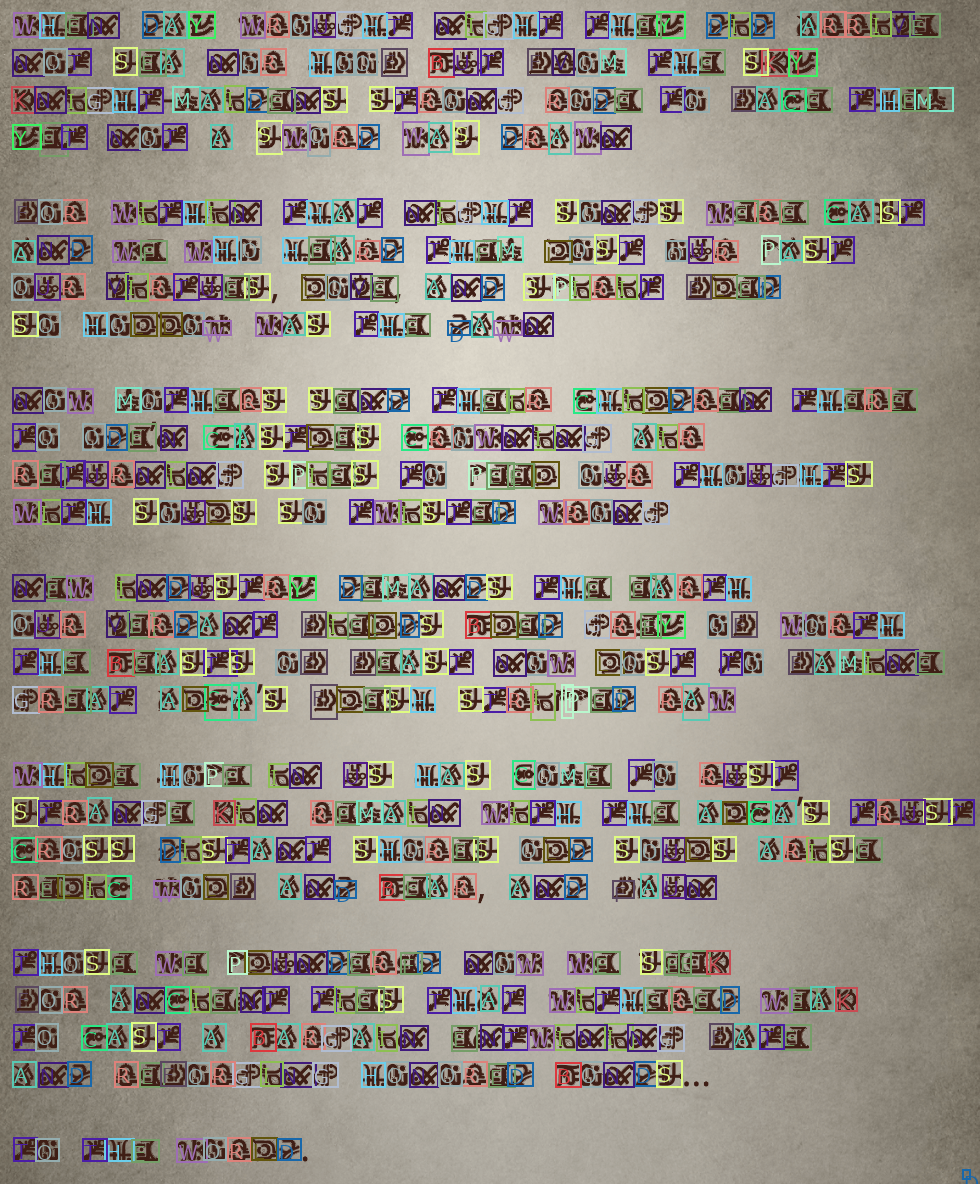

195
tensor([[  85.4243,   87.2563,  113.2225,  113.1235],
        [  66.6938,   48.3626,   91.9774,   75.8803],
        [  65.6389,   86.8434,   86.5258,  113.3260],
        ...,
        [ 960.0000,  800.0000,  975.6147,  818.9974],
        [ 960.0000,  801.2208,  974.1838,  822.2809],
        [ 962.3561, 1169.0359,  970.8695, 1179.0044]], grad_fn=<CatBackward0>)


In [16]:
filterThreshold = 0.5

computeNeighbors(full_results,nX,nY,2)
mod_results = sortResults(full_results)
filterResults(mod_results,filterThreshold)
resultsToLists(mod_results)
#print(mod_results['groups'])
#print(mod_results['neighbors'])
#print(sum([len(i) for i in mod_results['groups']]))
#print(sum([len(i) for i in mod_results['neighbors']]))
#print(sum([len(i) for i in mod_results['groups']]))
removeOverlaps(mod_results)
#print(sum([len(i) for i in mod_results['groups']]))
#print(mod_results['groups'])
#displayCoords(test_img, mod_results['boxes'], mod_results['labels'])
displayGroups(test_img, mod_results, [i for i in range(len(mod_results['groups']))])
#displayGroups(test_img, mod_results, [77,78,88,89])
print(len(mod_results['groups']))

#print(len(full_results['boxes']))
#print(full_results['labels'])
#print(full_results['scores'])
print(full_results['boxes'])